# 3. EDA
This notebook aims to use perform EDA

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -qqq emoji fasttext

In [3]:
# Import packages
import os
import pandas as pd
import numpy as np
import itertools
import collections
import networkx as nx
import six
import matplotlib.pyplot as plt
import seaborn as sns
import emoji as em
import fasttext
import re

from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, ImageColorGenerator
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from PIL import Image

import nltk
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Change to own directory
try:
    os.chdir("/content/drive/MyDrive/MyProject_SIDetection")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


In [5]:
# Set constants
SEED = 4222

## Original Dataset

In [6]:
# Load original dataset
df = pd.read_csv('Suicide_Detection.csv',index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [7]:
# Check for null values
df.isnull().sum()

text     0
class    0
dtype: int64

suicide        116037
non-suicide    116037
Name: class, dtype: int64
suicide        0.5
non-suicide    0.5
Name: class, dtype: float64


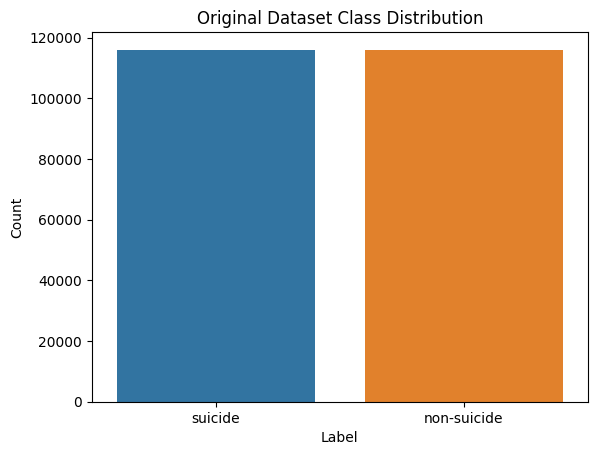

In [8]:
# Check class distribution
print(df['class'].value_counts())
print(df['class'].value_counts(normalize=True))

sns.countplot(x=df['class'])
plt.title('Original Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [9]:
# Check lowercase
lowercase = df['text'].str.islower()
print(lowercase.value_counts())

False    214395
True      17679
Name: text, dtype: int64


In [10]:
# Check extra whitespace
extra_whitespace = df['text'].str.match('\s\s+')
print(extra_whitespace.value_counts())

df['text'][extra_whitespace == True]

False    232073
True          1
Name: text, dtype: int64


6788    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
Name: text, dtype: object

In [11]:
# Check URL
url = df['text'].str.contains("http")
print(url.value_counts())

False    224921
True       7153
Name: text, dtype: int64


In [12]:
# Check mentions
mention = df['text'].str.match('@(\w+)')
print(mention.value_counts())

df['text'][mention == True]

False    232072
True          2
Name: text, dtype: int64


70950    @everyone do you like dick? balls? Maybe cock ...
78446    @everyone @everyone Oh.......\n\n this doesn't...
Name: text, dtype: object

In [13]:
# Check hashtags
hashtag = df['text'].str.match('#(\w+)')
print(hashtag.value_counts())

df['text'][hashtag == True]

False    232061
True         13
Name: text, dtype: int64


1427      #3737 is the parking stall number my body woul...
2760      #1 Tip for College: Don't Fucking Go **College...
58925     #EVERYONE, THE MALE SNOO IS KIDNAPPED BY A GAY...
87502     #PHX Choosing life over love...I'm not from he...
109318    #carsondidnothingwrong If you agree tell me wh...
109507    #It feels like god doesn't want me to live or ...
127591    #I CONFESS TO MY CRUSH. Yay Firstly sorry for ...
129500    #sober challenge I'm gonna try to be sober for...
134073    #donaldtrumpisoverparty Let's get this trendin...
134830    #27clubI turn 27 in 16 days. I wanna leave my ...
140018    #crazysockz4docsAs someone who will one day be...
172476    #AllMen was actually trending today? Jesus fuc...
181590    #Day 14 of Working out Hey, guys still doing g...
Name: text, dtype: object

In [14]:
# Check subreddit tag
subreddit = df['text'].str.match('r/(\w+)')
print(subreddit.value_counts())

#df['text'][subreddit == True]

False    231990
True         84
Name: text, dtype: int64


In [15]:
# Check users tag
users = df['text'].str.match('u/(\w+)')
print(users.value_counts())

# df['text'][users == True]

False    231859
True        215
Name: text, dtype: int64


In [16]:
# Check special characters
special_characters = df['text'].str.match('[^0-9a-zA-Z ]+')
print(special_characters.value_counts())

df['text'][special_characters == True]

False    229648
True       2426
Name: text, dtype: int64


6         [Trigger warning] Excuse for self inflicted bu...
129       *angry button fingering* "I'm trying to sleep,...
132       .Fuckin a man. Why is it there isn’t a single ...
149       İ am losing my mind...İ dont know how i can en...
343       [Important] TikTok is NOT for kids. TikTok is ...
                                ...                        
231808    (x-post r/depression) how do you cope?Its been...
231901    "SoRry YoUr PoSt WaS tO sHoRt" Does it fucking...
231914    [Interactive Quiz] On a lighter note, see if y...
231951    "If you were really suicidal [...]"Am I not?\n...
232031    (My crush likes me!!! Don’t worry that’s not t...
Name: text, Length: 2426, dtype: object

In [17]:
# Check emoji
def text_has_emoji(text):
    for character in text:
        if character in em.EMOJI_DATA:
            return True
    return False

emoji = df['text'].apply(text_has_emoji)
print(emoji.value_counts())

# df['text'][emoji == True]

False    221956
True      10118
Name: text, dtype: int64


In [18]:
def count_emojis(text):
    return len([c for c in text if c in em.EMOJI_DATA.keys()])

emoji = df['text'].apply(count_emojis)
print(emoji.value_counts())

# df['text'][emoji > 0]

0       221956
1         5086
2         1924
3         1102
4          519
         ...  
29           1
1210         1
1730         1
2464         1
131          1
Name: text, Length: 160, dtype: int64


In [19]:
# Check language
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

PRETRAINED_FASTTEXT_PATH = '/tmp/lid.176.bin'
model = fasttext.load_model(PRETRAINED_FASTTEXT_PATH)

def check_language(text):
  sentences = text.split("\n")
  predictions = model.predict(sentences)
  language = predictions[0][0][0].split("__label__")[1]
  confidence = predictions[1][0][0]

  return language

language = df['text'].apply(check_language)
print(language.value_counts())

# df['text'][language != 'en']

--2023-12-21 23:20:40--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.72, 18.164.78.121, 18.164.78.81, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125.18M   178MB/s    in 0.7s    

2023-12-21 23:20:40 (178 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]



en     229334
de        596
ca        362
ja        353
si        166
        ...  
te          1
jbo         1
tt          1
cy          1
bg          1
Name: text, Length: 90, dtype: int64


## Cleaned Dataset

In [20]:
# compare text_clean_without_emojis only

clean_df = pd.read_csv('data_heavyclean.csv', header=0)
clean_df

,text,label
0,ex wife threatening suiciderecently left wife ...,1
1,weird get affected compliment coming someone k...,0
2,finally 2020 almost never hear 2020 bad year e...,0
3,need helpjust help im cry hard,1
4,end tonight anymore quit,1
...,...,...
174290,something today went sledding friend may seem ...,0
174291,like rock going get anything go,0
174292,tell many friend lonely everything deprived pr...,0
174293,pee probably taste like salty tea someone dran...,0


In [21]:
# Check for null values
clean_df.isnull().sum()

text     0
label    0
dtype: int64

In [22]:
# Split dataset into train and test sets
train_data, test_data = train_test_split(clean_df,
                                         test_size=0.2,
                                         random_state=SEED,
                                         stratify=clean_df['label'])

In [23]:
# Split train set into classes
train_data_suicidal = train_data[train_data['label'] == 1]
train_data_nonsuicidal = train_data[train_data['label'] == 0]

### Full dataset

0    107027
1     67268
Name: label, dtype: int64
0    0.614057
1    0.385943
Name: label, dtype: float64


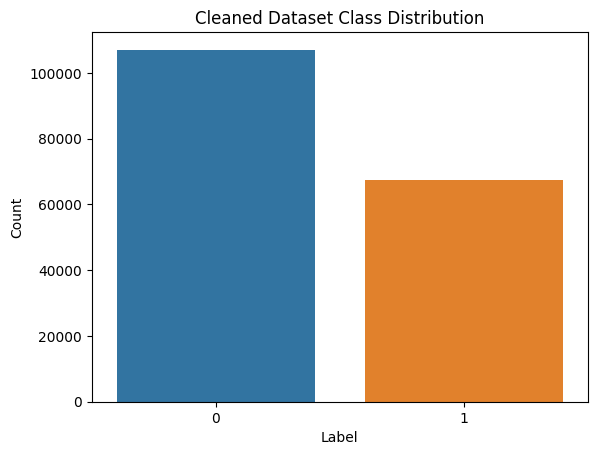

In [24]:
# Check class distribution
print(clean_df['label'].value_counts())
print(clean_df['label'].value_counts(normalize=True))

sns.countplot(x=clean_df['label'])
plt.title('Cleaned Dataset Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Train dataset

0    85622
1    53814
Name: label, dtype: int64
0    0.614059
1    0.385941
Name: label, dtype: float64


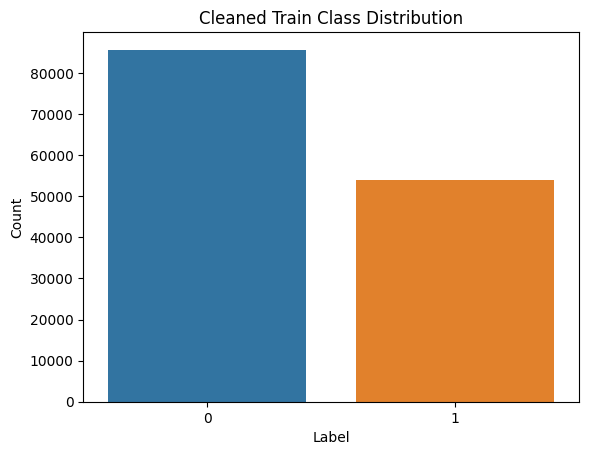

In [25]:
# Check class distribution
print(train_data['label'].value_counts())
print(train_data['label'].value_counts(normalize=True))

sns.countplot(x=train_data['label'])
plt.title('Cleaned Train Class Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## Suicidal Text

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_suicidal['text'])

In [27]:
tokenizer.word_counts.items()

odict_items([('sleep', 2454), ('fantasizing', 71), ('deathi', 70), ('depressed', 3012), ('10', 836), ('year', 10274), ('whole', 1263), ('adult', 290), ('life', 23051), ('tired', 5776), ('wanna', 2613), ('anymore', 11038), ('know', 21989), ('kill', 10849), ('would', 11337), ('painful', 854), ('people', 12906), ('love', 5325), ('sometimes', 1427), ('wish', 4970), ('big', 632), ('deal', 1554), ('someone', 8211), ('choose', 276), ('check', 404), ('like', 23359), ('quitting', 52), ('game', 679), ('play', 396), ('something', 4870), ('need', 8278), ('commit', 1268), ('exactly', 354), ('happened', 919), ('want', 33840), ('live', 7541), ('better', 7145), ('act', 617), ('initial', 16), ('feeling', 5797), ('giving', 738), ('week', 3230), ('get', 16301), ('everything', 7268), ('order', 270), ('finally', 2226), ('make', 8699), ('irreversible', 20), ('decision', 599), ('asking', 553), ('write', 765), ('debt', 518), ('transferred', 15), ('family', 6731), ('die', 11116), ('carbon', 86), ('monoxide', 7

In [28]:
word_freq_suicidal = pd.DataFrame(tokenizer.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)

### Word Frequency Bar Graph

Text(0, 0.5, 'Word')

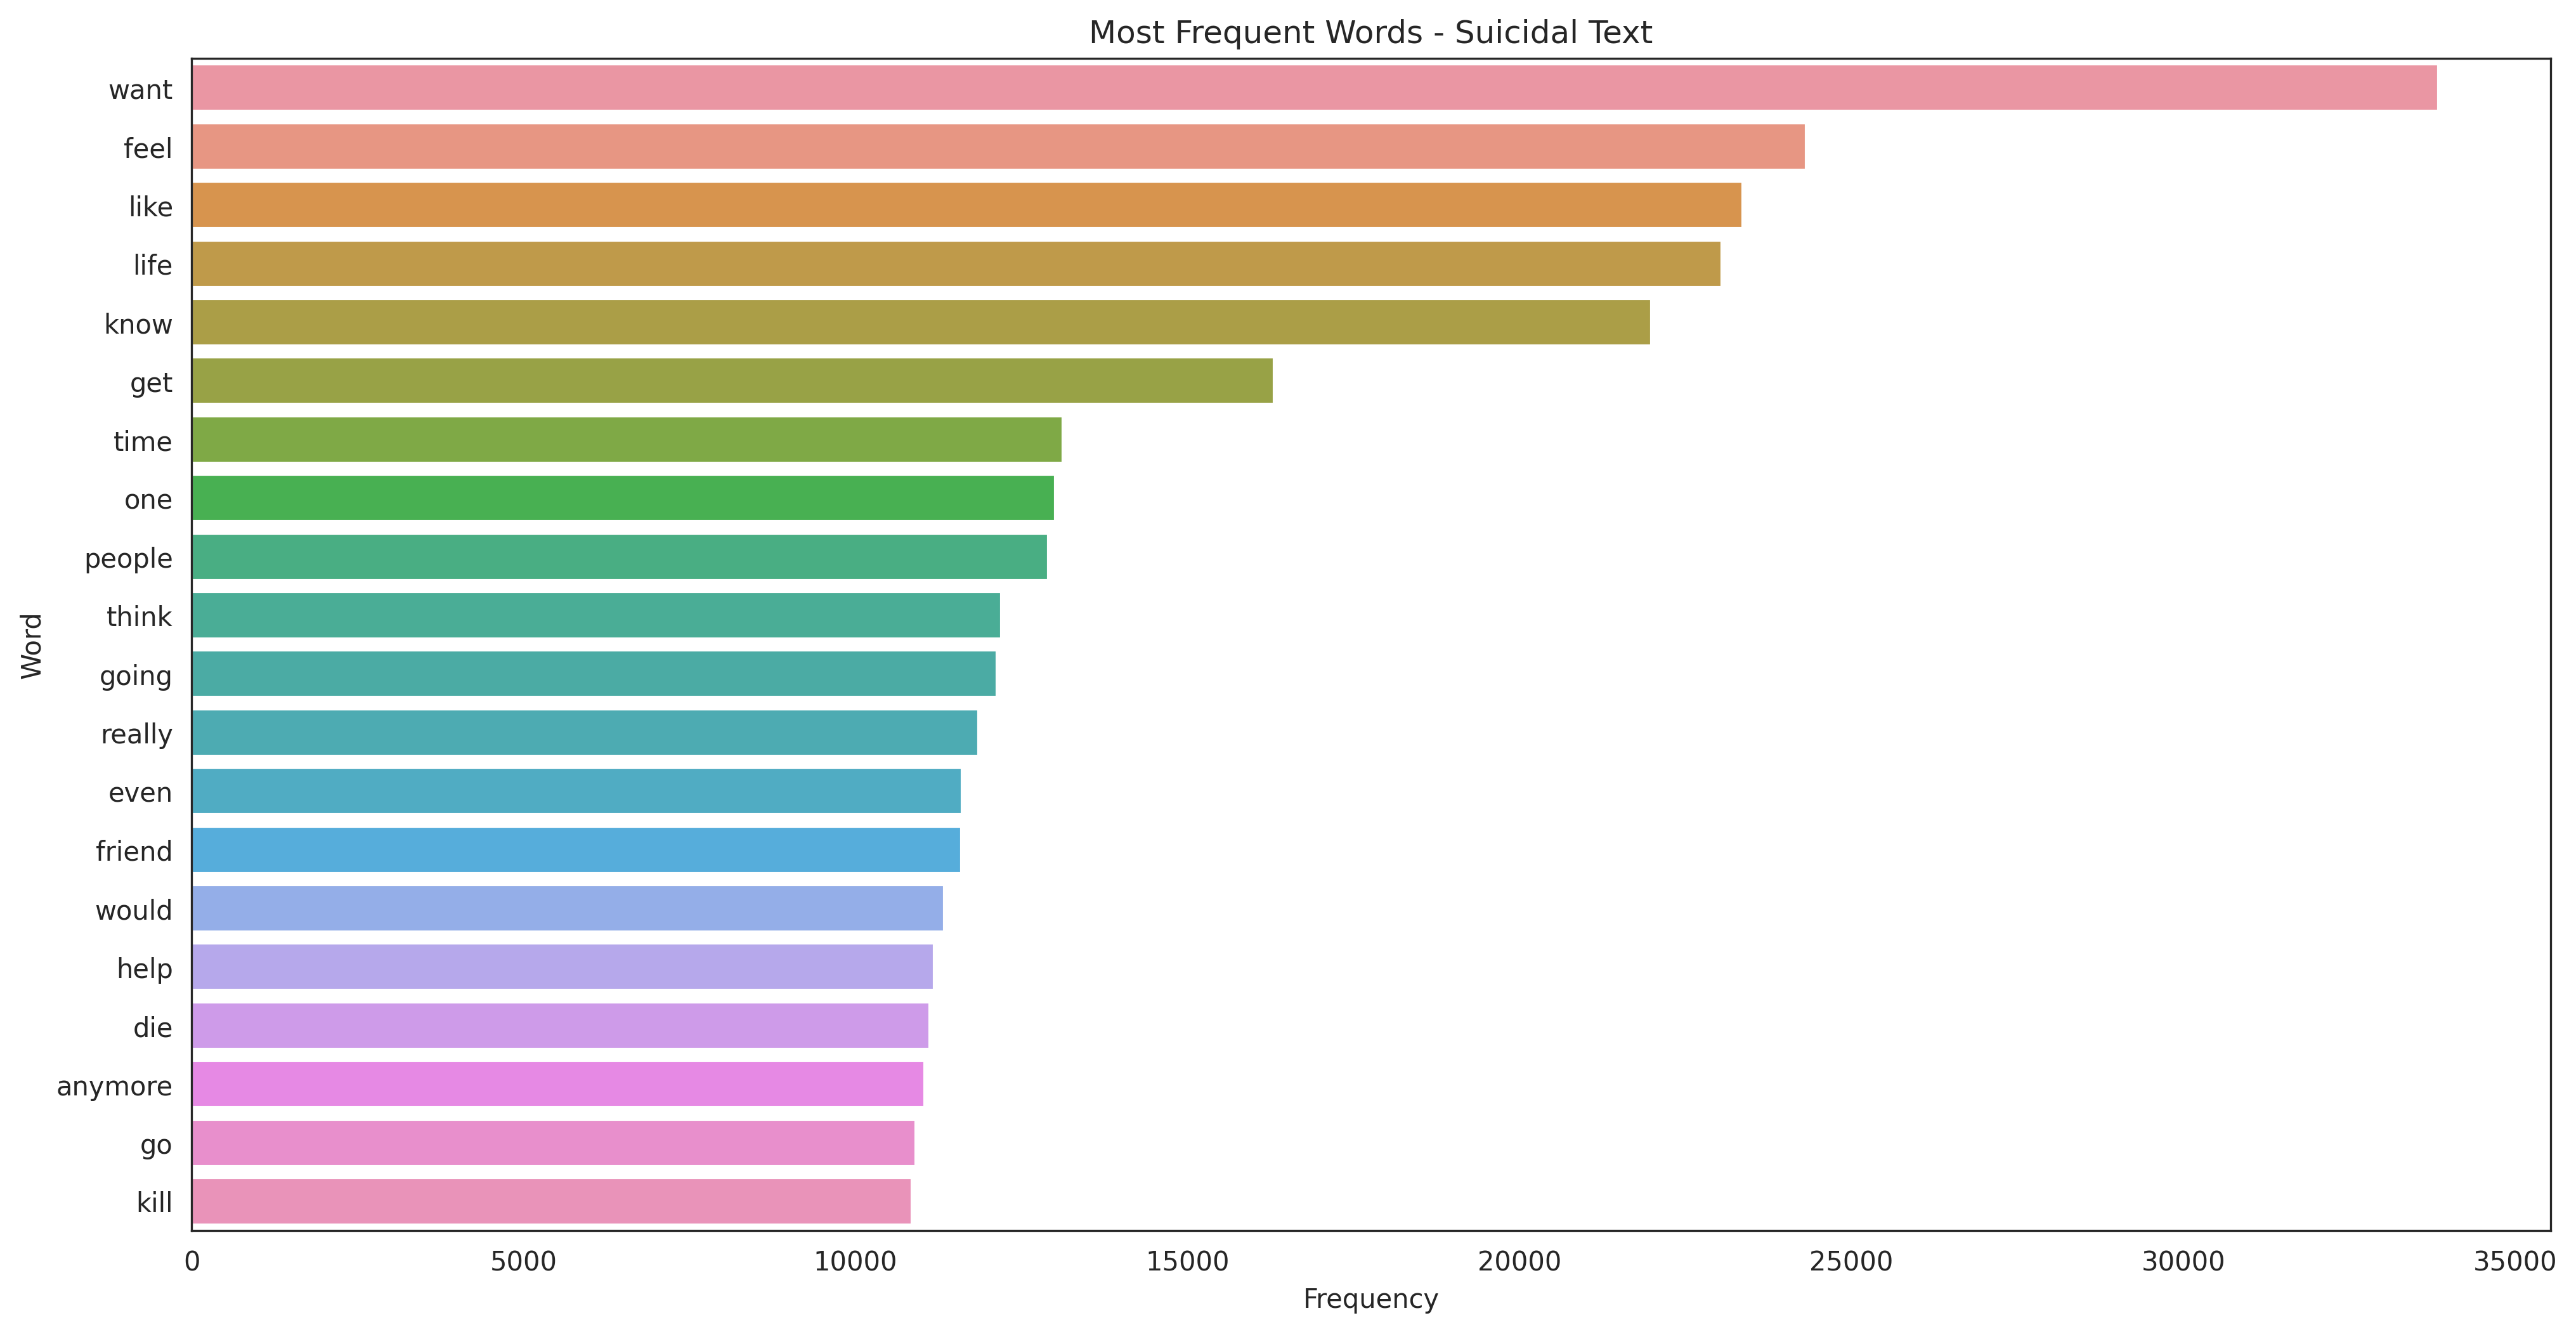

In [29]:
# Word Frequency Bar Graph
sns.set_style("white")
plt.figure(figsize = (16, 8), dpi=300)
ax = sns.barplot(x='count',y='word',data=word_freq_suicidal.iloc[:20])
plt.title('Most Frequent Words - Suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")

### Wordcloud

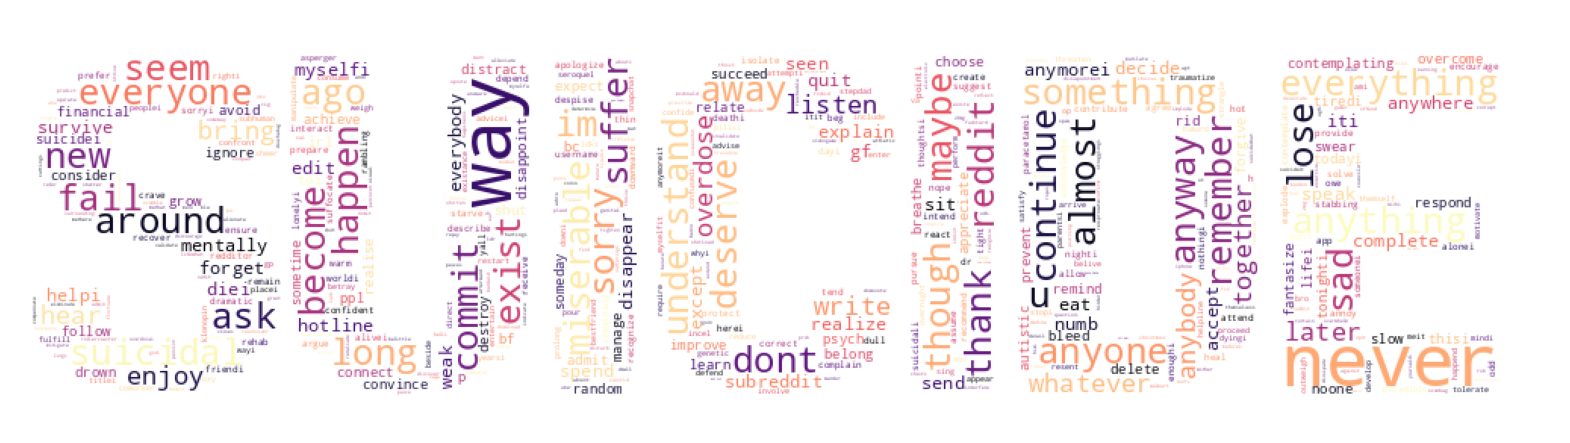

In [30]:
# Wordcloud
feature_names=word_freq_suicidal['word'].values
mask = np.array(Image.open("suicide_mask.png"))
wc=WordCloud(repeat=True, collocations=False,min_font_size=2, max_font_size= 80, max_words= 500, background_color="white", width=2000, height=1000, colormap= "magma", mask= mask)
wc.generate(' '.join(word for word in feature_names))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

### Distribution of Text Length

In [31]:
# Get average text length
train_data_suicidal = train_data_suicidal.copy()
train_data_suicidal['text'] = train_data_suicidal['text'].astype(str)
train_data_suicidal['length'] = train_data_suicidal['text'].apply(lambda x: len(x.split()))

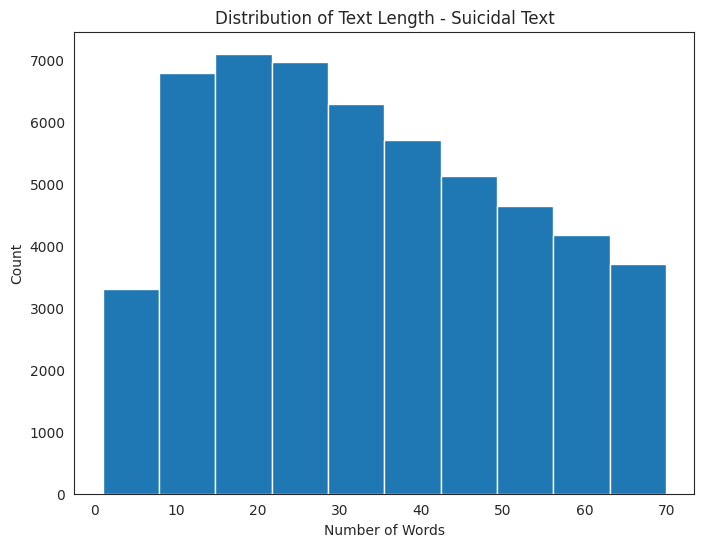

In [32]:
# Plot average text length
ax = train_data_suicidal['length'].plot(kind='hist',title='Distribution of Text Length - Suicidal Text', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()

### Polarity Score Distribution

In [33]:
# Polarity score distribution
def get_polarity(text):
  return TextBlob(text).sentiment.polarity
train_data_suicidal['Polarity'] = train_data_suicidal['text'].apply(get_polarity)

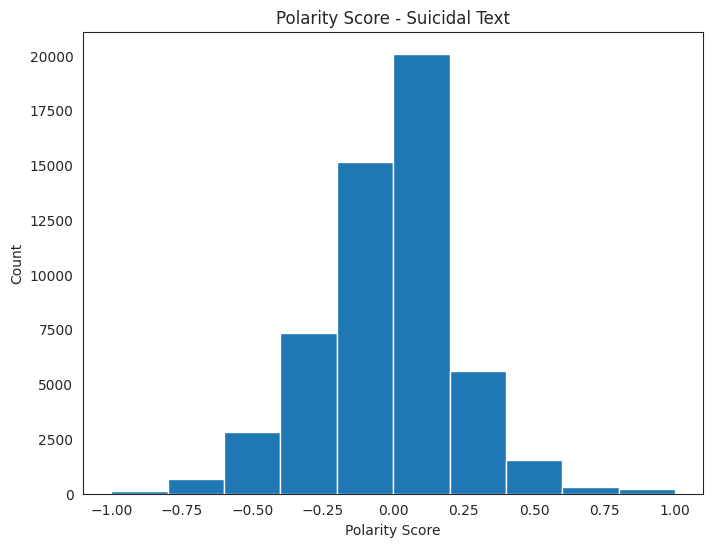

In [34]:
# Plot polarity score graph
ax = train_data_suicidal['Polarity'].plot(kind='hist', title='Polarity Score - Suicidal Text', figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

### Bigram

In [35]:
print('The nltk version is {}.'.format(nltk.__version__))

The nltk version is 3.8.1.


In [36]:
#Remove more stop words and do bigram
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
train_data_suicidal['without_stopwords'] = train_data_suicidal['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

from nltk import bigrams
sentences = [text.split() for text in train_data_suicidal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

bigram_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Bigram,Count
0,"(feel, like)",9381
1,"(want, die)",4078
2,"(get, better)",2252
3,"(want, kill)",1821
4,"(suicidal, thought)",1565
5,"(want, end)",1537
6,"(every, day)",1462
7,"(want, live)",1330
8,"(wish, could)",1266
9,"(really, want)",1256


<Axes: >

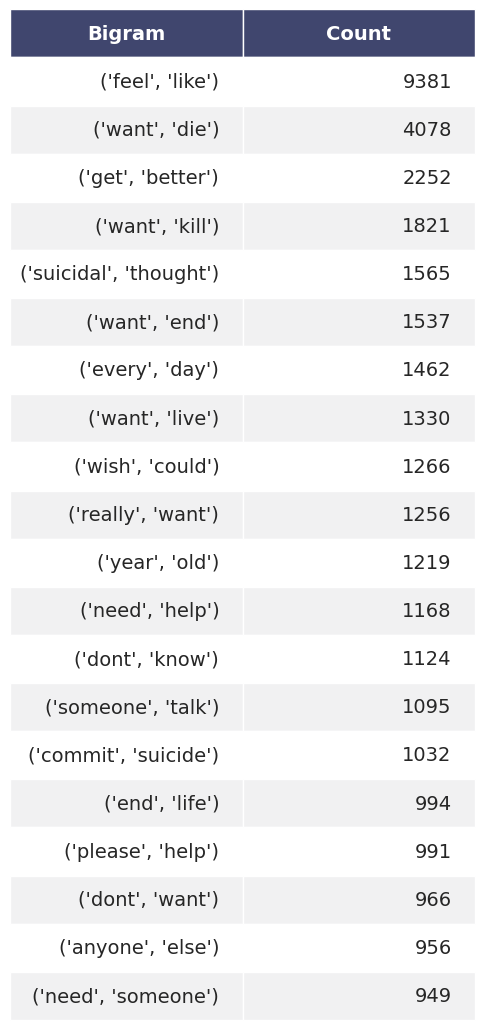

In [37]:
#To make the table nicer
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(bigram_df, header_columns=0, col_width=3)

### Trigram

In [39]:
from nltk import trigrams
# Create list of lists containing trigrams
terms_trigram = [list(trigrams(text)) for text in sentences]

# Filter trigrams to exclude those with the same word repeated
filtered_terms_trigram = [
    [trigram for trigram in trigram_list if len(set(trigram)) > 1]
    for trigram_list in terms_trigram
]

# Flatten the filtered list of trigrams
filtered_trigrams = list(itertools.chain(*filtered_terms_trigram))

# Create counter of words in clean filtered trigrams
filtered_trigram_counts = collections.Counter(filtered_trigrams)

# Create a table of the top 20 most frequent filtered trigrams
filtered_trigram_df = pd.DataFrame(filtered_trigram_counts.most_common(20),
                                   columns=['Trigram', 'Count'])


filtered_trigram_df

,Trigram,Count
0,"(need, someone, talk)",566
1,"(want, die, want)",456
2,"(want, live, anymore)",321
3,"(thing, get, better)",279
4,"(really, want, die)",243
5,"(every, single, day)",242
6,"(feel, like, life)",206
7,"(feel, like, one)",205
8,"(know, much, longer)",204
9,"(feel, like, shit)",201


<Axes: >

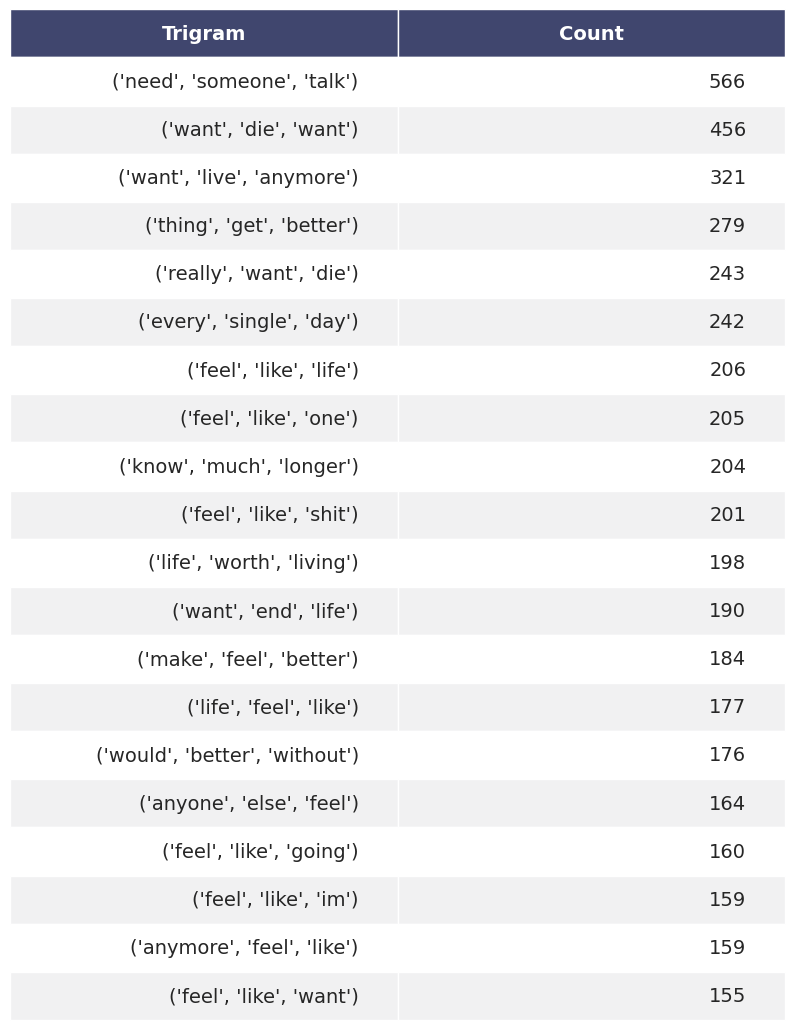

In [40]:
render_mpl_table(filtered_trigram_df, header_columns=0, col_width=5)

## Non-suicidal Text

In [41]:
tokenizer_nonsuicidal = Tokenizer()
tokenizer_nonsuicidal.fit_on_texts(train_data_nonsuicidal["text"])

In [42]:
tokenizer_nonsuicidal.word_counts.items()

odict_items([('well', 2696), ('fuck', 4728), ('girlfriend', 1692), ('cool', 1956), ('getting', 2607), ('mullet', 25), ('fucking', 5192), ('might', 1839), ('ily', 56), ('supporting', 58), ('bad', 3753), ('decision', 176), ('feeling', 2376), ('someone', 6181), ('okay', 1071), ('recently', 870), ('talking', 2217), ('lot', 2697), ('girl', 8055), ('fourth', 37), ('block', 225), ('current', 187), ('event', 178), ('class', 3100), ('developed', 55), ('one', 10176), ('never', 3912), ('felt', 970), ('strange', 202), ('also', 4376), ('contempt', 2), ('comforting', 29), ('asked', 1749), ('could', 3547), ('friend', 10169), ('said', 4447), ('yes', 1760), ('sister', 878), ('brother', 1037), ('life', 4670), ('near', 247), ('u', 6228), ('always', 2568), ('see', 4444), ('hand', 1051), ('advice', 1835), ('would', 7122), ('want', 12425), ('potentially', 35), ('start', 2238), ('friendship', 273), ('later', 825), ('relationship', 1360), ('autistic', 41), ('person', 2923), ('hi', 1167), ('help', 6422), ('guy

In [43]:
word_freq_nonsuicidal = pd.DataFrame(tokenizer_nonsuicidal.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq_nonsuicidal.head()

,word,count
77,like,27695
144,get,13873
99,know,13041
47,want,12425
78,people,11343


### Word Frequency Bar Graph

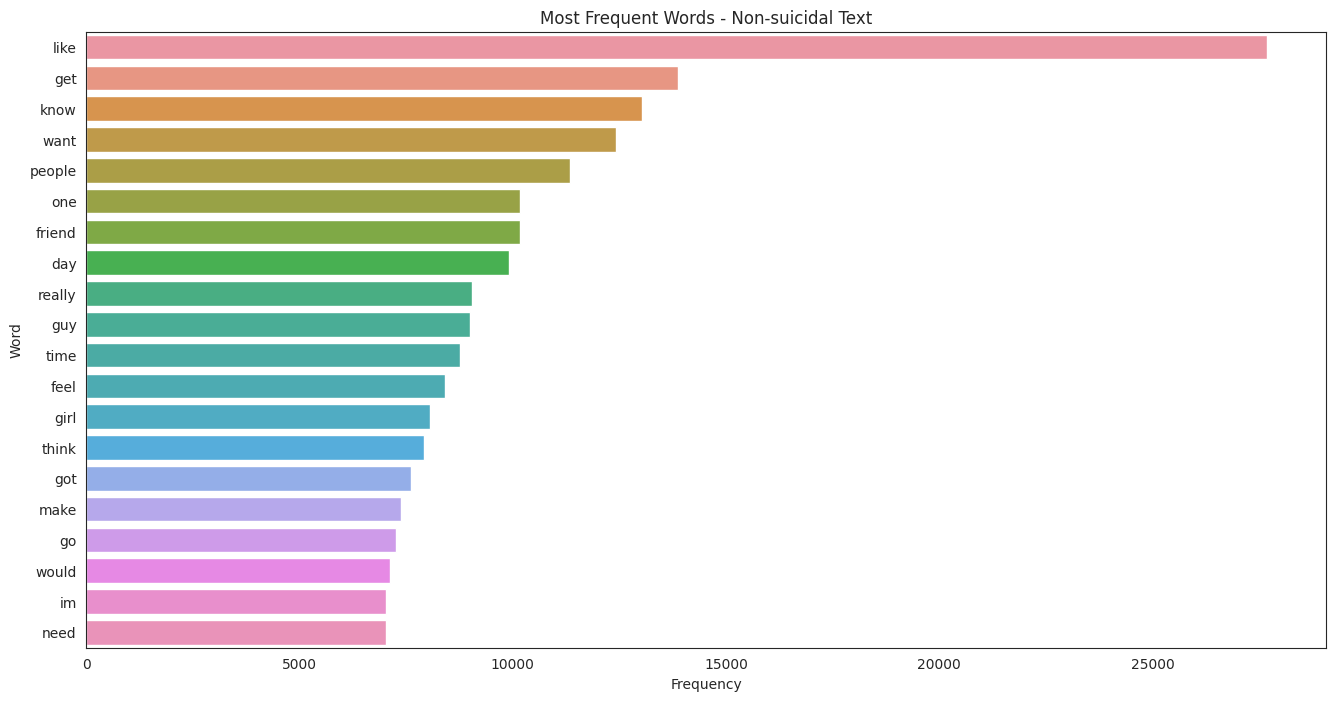

In [44]:
# Word Frequency Bar Graph
plt.figure(figsize=(16, 8))
sns.barplot(x='count', y='word', data=word_freq_nonsuicidal.iloc[:20])
plt.title('Most Frequent Words - Non-suicidal Text')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

### Wordcloud

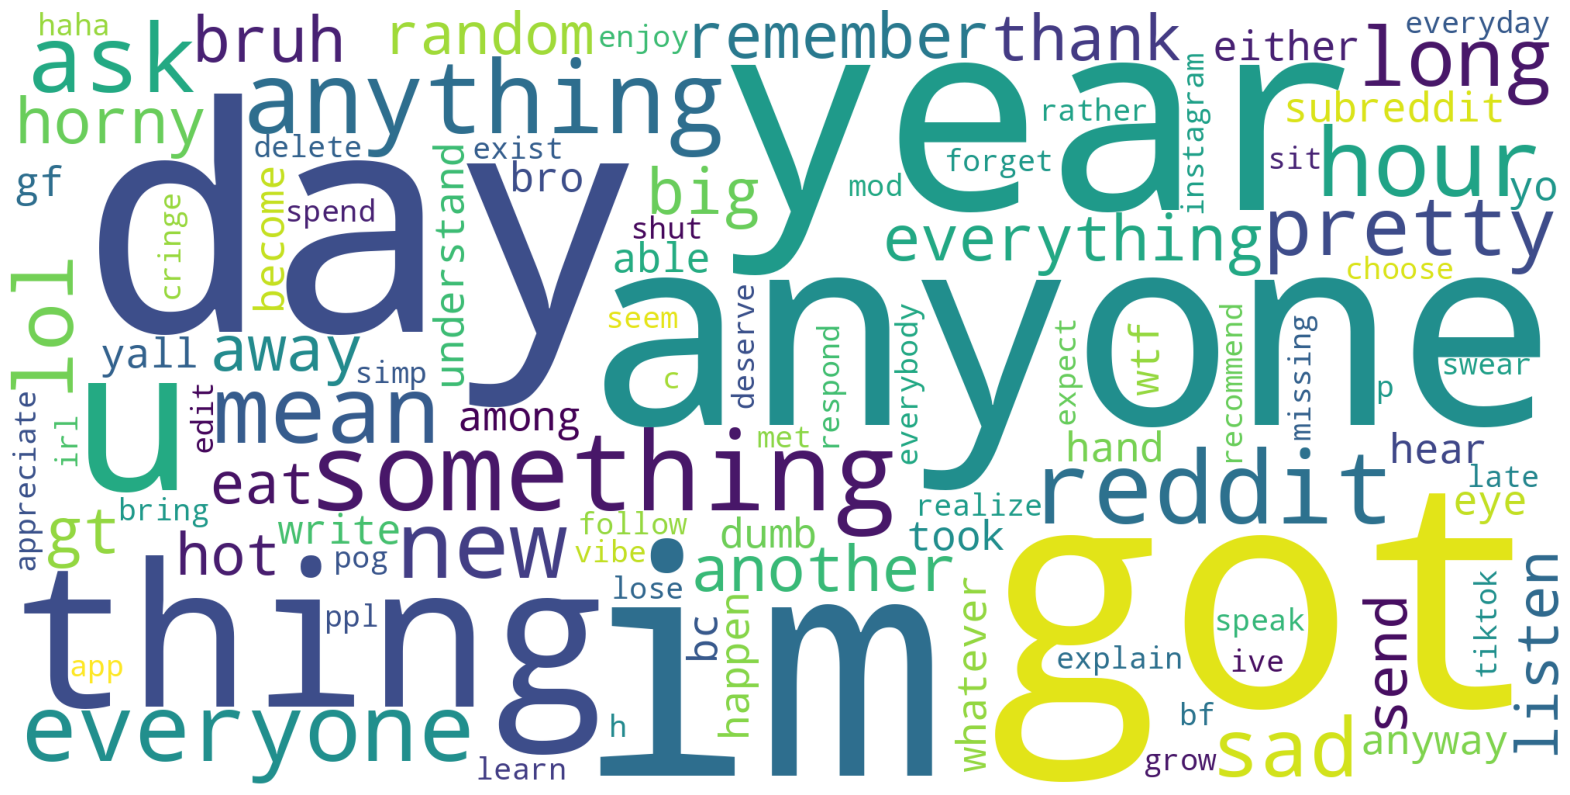

In [45]:
# Wordcloud
feature_names_nonsuicidal = word_freq_nonsuicidal['word'].values
wc = WordCloud(max_words=100, background_color="white", width=2000, height=1000)
wc.generate(' '.join(word for word in feature_names_nonsuicidal))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)
plt.show()

### Distribution of Text Length

In [46]:
# Get average text length
train_data_nonsuicidal = train_data_nonsuicidal.copy()
train_data_nonsuicidal['text'] = train_data_nonsuicidal['text'].astype(str)
train_data_nonsuicidal['length'] = train_data_nonsuicidal['text'].apply(lambda x: len(x.split()))

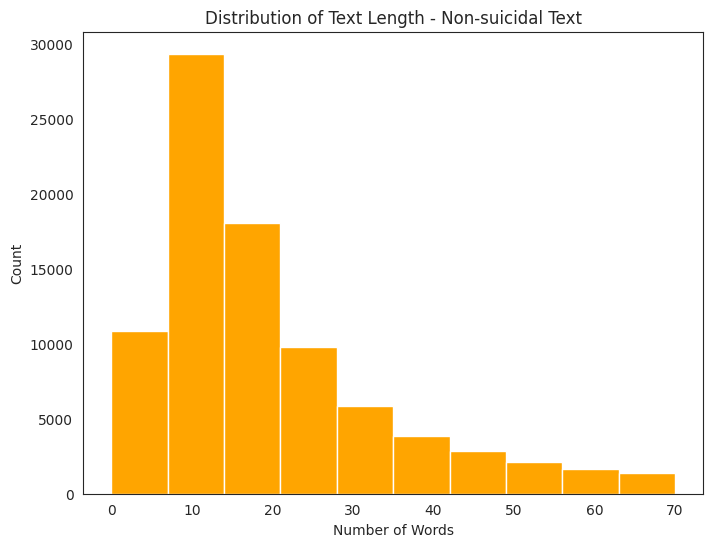

In [47]:
# Plot distribution of text length
ax = train_data_nonsuicidal['length'].plot(kind='hist',title='Distribution of Text Length - Non-suicidal Text', color='orange', figsize=(8,6))
ax.set_xlabel("Number of Words")
ax.set_ylabel("Count")
plt.show()

### Polarity Score Distribution

In [48]:
# Polarity score distribution
train_data_nonsuicidal['text'] = train_data_nonsuicidal['text'].astype('str')
train_data_nonsuicidal['Polarity'] = train_data_nonsuicidal['text'].apply(get_polarity)

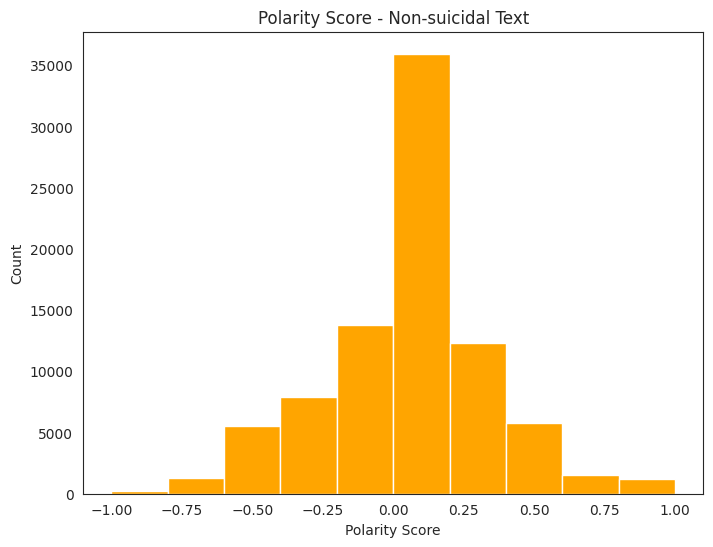

In [49]:
# Plot polarity score graph
ax = train_data_nonsuicidal['Polarity'].plot(kind='hist', title='Polarity Score - Non-suicidal Text', color="orange", figsize=(8,6))
ax.set_xlabel("Polarity Score")
ax.set_ylabel("Count")
plt.show()

### Bigram

In [50]:
#import nltk
#nltk.download('stopwords')
#stop_words = stopwords.words('english')

In [51]:
train_data_nonsuicidal['without_stopwords'] = train_data_nonsuicidal['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
from nltk import bigrams
sentences = [text.split() for text in train_data_nonsuicidal['without_stopwords']]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in sentences]

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

#Create a table of the top 20 most paired words
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['Bigram', 'Count'])

bigram_df

,Bigram,Count
0,"(feel, like)",2934
1,"(anyone, else)",1284
2,"(year, old)",1197
3,"(need, help)",1109
4,"(anyone, wanna)",1005
5,"(among, u)",840
6,"(best, friend)",740
7,"(look, like)",731
8,"(first, time)",725
9,"(anyone, want)",634


<Axes: >

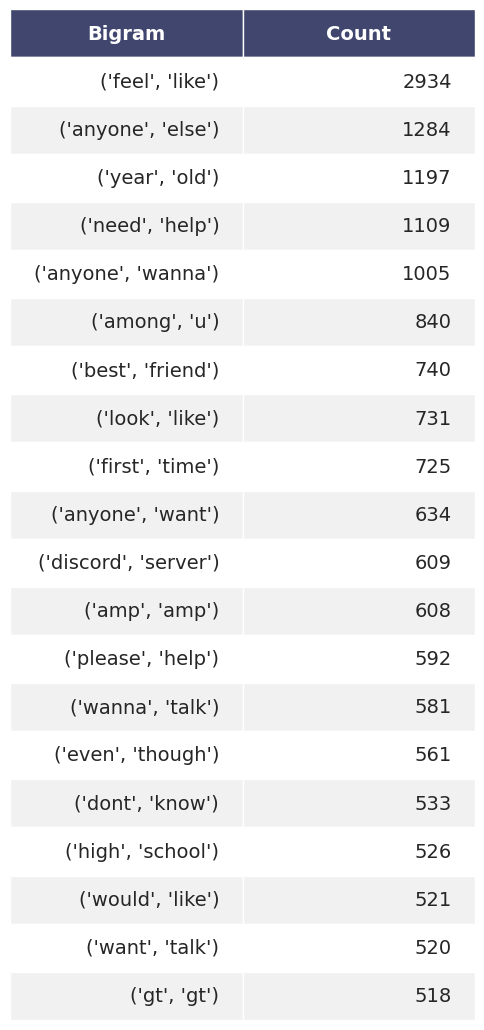

In [52]:
render_mpl_table(bigram_df, header_columns=0, col_width=3)

### Trigram

In [53]:
from nltk import trigrams
# Create list of lists containing trigrams
terms_trigram = [list(trigrams(text)) for text in sentences]

# Filter trigrams to exclude those with the same word repeated
filtered_terms_trigram = [
    [trigram for trigram in trigram_list if len(set(trigram)) > 1]
    for trigram_list in terms_trigram
]

# Flatten the filtered list of trigrams
filtered_trigrams = list(itertools.chain(*filtered_terms_trigram))

# Create counter of words in clean filtered trigrams
filtered_trigram_counts = collections.Counter(filtered_trigrams)

# Create a table of the top 20 most frequent filtered trigrams
filtered_trigram_df = pd.DataFrame(filtered_trigram_counts.most_common(20),
                                   columns=['Trigram', 'Count'])


filtered_trigram_df

,Trigram,Count
0,"(anyone, wanna, chat)",271
1,"(anyone, wanna, talk)",246
2,"(coming, ted, talk)",226
3,"(14, year, old)",134
4,"(13, year, old)",132
5,"(play, among, u)",131
6,"(anyone, want, talk)",131
7,"(feel, like, shit)",130
8,"(anyone, wanna, play)",128
9,"(thank, coming, ted)",125


<Axes: >

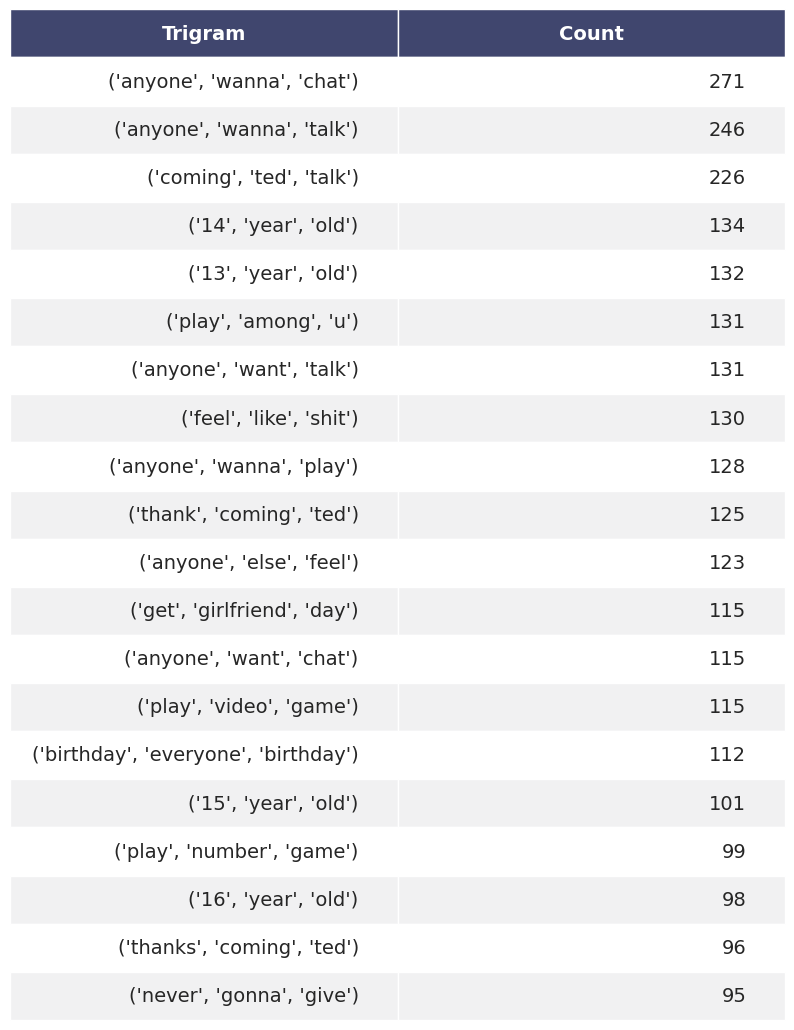

In [54]:
render_mpl_table(filtered_trigram_df, header_columns=0, col_width=5)